In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, random
from scipy.optimize import curve_fit
from scipy.special import gamma

BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'
aspect_ratio = 16./9

From _Numerical Recipes_, ch. 15.2:
$$
S = \sum_{i=0}^{N-1} \frac{1}{\sigma_i^2}, 
S_x = \sum_{i=0}^{N-1} \frac{x_i}{\sigma_i^2}, 
S_y = \sum_{i=0}^{N-1} \frac{y_i}{\sigma_i^2}, 
S_{xx} = \sum_{i=0}^{N-1} \frac{x_i^2}{\sigma_i^2}, 
S_{xy} = \sum_{i=0}^{N-1} \frac{x_i y_i}{\sigma_i^2}
$$

$$
\Delta = S S_{xx} - \left( S_x \right)^2, 
b = \frac{S_{xx} S_y - S_x S_{xy}}{\Delta},
m = \frac{S S_{xy} - S_x S_y}{\Delta}
$$

$$
\sigma_b^2 = \frac{S_{xx}}{\Delta},
\sigma_m^2 = \frac{S}{\Delta}, \sigma_{bm} = -\frac{S_x}{\Delta}
$$

The velocity profile is given by
$$
u(z) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_\star} \right)
$$
with $z_\star$ as the roughness scale (as opposed to the usual $z_0$).

Re-casting as a linear fit:$y_i = m x_i + b$ with $x_i = \ln \left( z_i / z_0 \right)$, $y_i = u(z_i)$, $m = u_\star/\kappa$, and $b = -\dfrac{u_\star}{\kappa} \ln \left( \dfrac{z_\star}{z_0} \right)$, where $z_0$ is the bottom anemometer height.

Assume logarithmic spacing, i.e. $\ln\left( z_i / z_0 \right) = i\ \delta x$.

In [2]:
def calc_S(sigma):
    return np.sum(1./sigma**2)

def calc_Sx(x, sigma):
    return np.sum(x/sigma**2)

def calc_Sxx(x, sigma):
    return np.sum(x**2/sigma**2)

def calc_Sy(y, sigma):
    return np.sum(y/sigma**2)

def calc_Syy(y, sigma):
    return np.sum(y**2/sigma**2)

def calc_Sxy(x, y, sigma):
    return np.sum(x*y/sigma**2)

def calc_Delta(x, sigma):
    S = calc_S(sigma)
    Sxx = calc_Sxx(x, sigma)
    Sx = calc_Sx(x, sigma)
    
    return S*Sxx - Sx**2

def calc_intercept(x, y, sigma):
    Sxx = calc_Sxx(x, sigma)
    Sy = calc_Sy(y, sigma)
    Sx = calc_Sx(x, sigma)
    Sxy = calc_Sxy(x, y, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (Sxx*Sy - Sx*Sxy)/Delta

def calc_slope(x, y, sigma):
    S = calc_S(sigma)
    Sxy = calc_Sxy(x, y, sigma)
    Sx = calc_Sx(x, sigma)
    Sy = calc_Sy(y, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (S*Sxy - Sx*Sy)/Delta

def calc_cov(x, sigma):
    return -calc_Sx(x, sigma)/calc_Delta(x, sigma)

def sigma_intercept(x, sigma):
    Sxx = calc_Sxx(x, sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(Sxx/Delta)

def sigma_slope(x, sigma):
    S = calc_S(sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(S/Delta)

In [3]:
def calc_analytic_Delta(delta_x, sigma, N):  
    return delta_x**2/12/sigma**4*N**2*(N**2 - 1)

def calc_analytic_S(sigma, N):
    return N/sigma**2

def calc_analytic_Sx(delta_x, sigma, N):
    return 0.5*delta_x/sigma**2*(N - 1)*N

def calc_analytic_Sxx(delta_x, sigma, N):
    return delta_x**2/sigma**2*(N - 1)*N*(2*N - 1)/6

def calc_analytic_Delta(delta_x, sigma, N):
    return delta_x**2/sigma**4/12*N**2*(N**2 - 1)

def calc_analytic_sigma_intercept(sigma, N):
    return np.sqrt(2.*sigma**2*(2*N - 1)/N/(N + 1))

def calc_analytic_sigma_slope(delta_x, sigma, N):
    return np.sqrt(12*sigma**2/delta_x**2/N/(N**2 - 1))

delta_x = np.log(2)
x = np.arange(0, 2)*delta_x
sigma = 5.*np.ones_like(x)
N = len(x)

# print(calc_analytic_Delta(delta_x, sigma[0], len(sigma)), calc_Delta(x, sigma))
# print(calc_analytic_S(sigma[0], N), calc_S(sigma))
# print(calc_analytic_Sx(delta_x, sigma[0], N), calc_Sx(x, sigma))
# print(calc_analytic_Sxx(delta_x, sigma[0], len(sigma)), calc_Sxx(x, sigma))
print(calc_analytic_Delta(delta_x, sigma[0], len(sigma)), calc_Delta(x, sigma))
# print(calc_analytic_sigma_intercept(sigma[0], len(sigma)), sigma_intercept(x, sigma))
# print(calc_analytic_sigma_slope(delta_x, sigma[0], len(sigma)), sigma_slope(x, sigma))

0.0007687248222691222 0.0007687248222691221


1.7148160424389385 0.9925464799451391
[1.93130908 1.11785403]


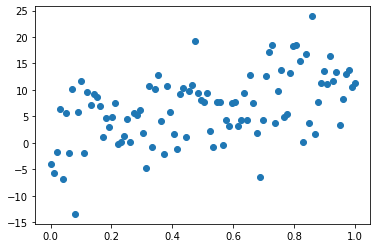

In [112]:
x = np.linspace(0, 1, 100)
slope = 10.
intercept = 1.
sigma = 5.*np.ones_like(x)
y = slope*x + intercept
noisy_y = y + normal(scale=sigma[0], size=len(x))

plt.scatter(x, noisy_y)
popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma, cov=True)
unc = np.sqrt(np.diag(pcov))
# print(popt)

print(sigma_slope(x, sigma), sigma_intercept(x, sigma))
print(unc)

analytic uncertainties:  0.0015811388300841897 0.007745966692414834
analytic cov:  -1e-05
numerical uncertainties:  [0.00051431 0.00251959]
numerical cov:  -1.0580569270921013e-06


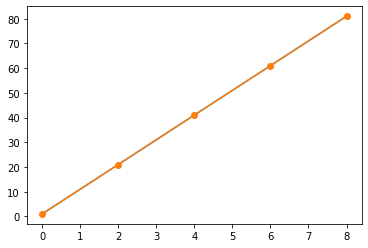

In [143]:
def lin_fit(x, m, b):
    return m*x + b

# Let's test these expressions
num_sensors = 5
delta_x = 2.
sigma = 0.01*np.ones(num_sensors)
slope = 10.
intercept = 1.

x = np.arange(num_sensors)*delta_x
y = np.polyval([slope, intercept], x)
noisy_y = y + normal(scale=sigma[0], size=num_sensors)

# print(calc_S(sigma), calc_Sxx(x, sigma), calc_Sx(x, sigma), calc_Delta(x, sigma))
# print("analytic slope and intercept: ", calc_slope(x, noisy_y, sigma), calc_intercept(x, noisy_y, sigma))
print("analytic uncertainties: ", sigma_slope(x, sigma), sigma_intercept(x, sigma))
print("analytic cov: ", calc_cov(x, sigma))

plt.plot(x, y)
plt.plot(x, noisy_y, marker='o')

# popt, pcov = curve_fit(lin_fit, x, noisy_y, sigma=sigma*np.ones_like(x), p0=[slope, intercept])
popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma, cov=True)
unc = np.sqrt(np.diag(pcov))
# print("numerical slope and intercept: ", popt)
print("numerical uncertainties: ", unc)
print("numerical cov: ", pcov[0,1])

# print(np.polyfit(x, noisy_y, 1, w=1./sigma*np.ones_like(x), full=True))

The numerical uncertainties shift around, even though NR tells me that the uncertainties out to be independent of the actual values for $y$. Oh, well, they are close enough.

See notes from 2022 Jul 8

How to propagate uncertainties on line slope $m$ and intercept $b$ into uncertainties on $u_\star$ and $z_\star$:
$$
\sigma_{z_\star} = \frac{z_\star}{m} \sqrt{ \sigma_b^2 + \left( \frac{b}{m} \right)^2 \sigma_m^2 - 2 \left( \frac{b}{m} \right) \sigma_{b m}}
$$

$$
\sigma_{u_\star} = \kappa \sigma_m
$$

Assuming logarithmically spaced anemometers with a constant uncertainty for each measurement:
$$
\sigma_{\rm b}^2 = \left( \dfrac{2 \left( 2N - 1 \right) }{N \left( N + 1 \right) } \right) \sigma^2 \\
\sigma_{\rm m}^2 = \left( \dfrac{12}{N \left( N^2 - 1 \right) \delta x^2 } \right) \sigma^2 \\
\sigma_{bm} = \dfrac{6 \sigma^2}{N \left( N + 1\right) \delta x }
$$

Text(2.1, 0.05, '$\\sigma_{u_\\star}/u_\\star$')

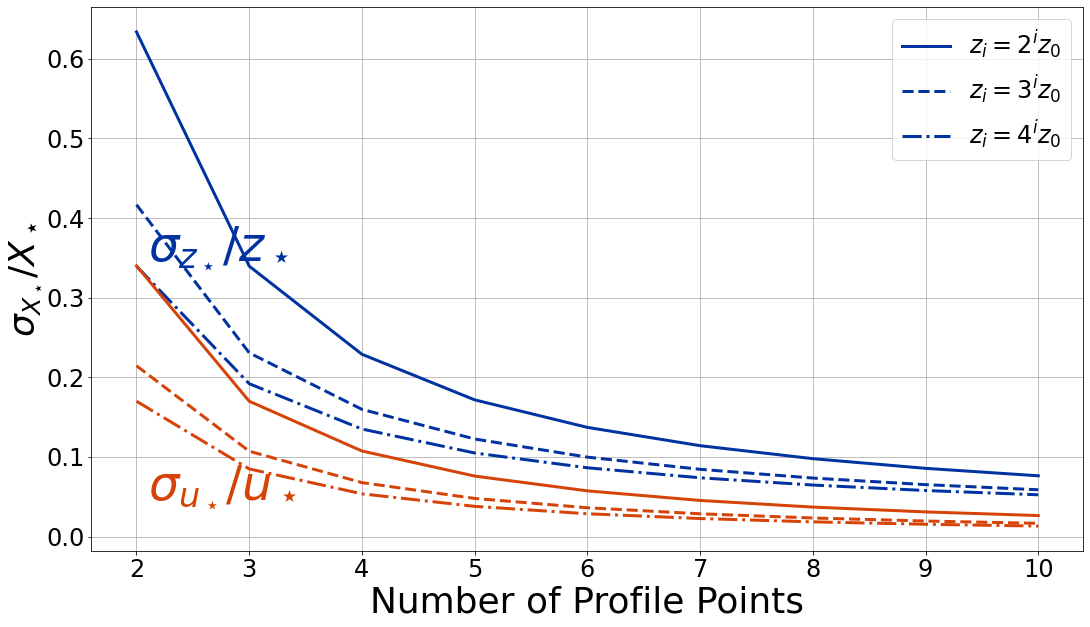

In [10]:
def calc_analytic_fractional_zstar_uncertainty(N, kappa=0.4, sigma_over_ustar=1./6, delta_x=np.log(2), 
                                               zstar_over_z0=75.):
    term1 = 2*(N - 1)/(N*(N + 1))
    term2 = np.log(zstar_over_z0)**2*12/(N*(N**2 - 1)*delta_x**2)
    term3 = 2*np.log(zstar_over_z0)*6/(N*(N + 1)*delta_x)
    
    return kappa*sigma_over_ustar*np.sqrt(term1 + term2 + term3)

def calc_analytic_fractional_ustar_uncertainty(N, kappa=0.4, sigma_over_ustar=1./6, delta_x=np.log(2)):
    return np.sqrt(12/(N*(N**2 - 1)))/delta_x*sigma_over_ustar

N = np.arange(2, 11)
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(111)
                   
ax1.plot(N, calc_analytic_fractional_zstar_uncertainty(N, delta_x=np.log(2)), 
         color=BoiseState_blue, lw=3, label=r'$z_i = 2^i z_0$')
ax1.plot(N, calc_analytic_fractional_zstar_uncertainty(N, delta_x=np.log(3)), 
                                                       color=BoiseState_blue, lw=3, ls='--', 
                                                       label=r'$z_i = 3^i z_0$')
ax1.plot(N, calc_analytic_fractional_zstar_uncertainty(N, delta_x=np.log(4)), 
         color=BoiseState_blue, lw=3, ls='-.', label=r'$z_i = 4^i z_0$')

ax1.plot(N, calc_analytic_fractional_ustar_uncertainty(N, delta_x=np.log(2)), 
         color=BoiseState_orange, lw=3)
ax1.plot(N, calc_analytic_fractional_ustar_uncertainty(N, delta_x=np.log(3)), 
                                                       color=BoiseState_orange, lw=3, ls='--')
ax1.plot(N, calc_analytic_fractional_ustar_uncertainty(N, delta_x=np.log(4)), 
         color=BoiseState_orange, lw=3, ls='-.')

ax1.legend(loc='upper right', fontsize=24)
ax1.grid(True)
ax1.set_xlabel('Number of Profile Points', fontsize=36)
ax1.set_ylabel(r'$\sigma_{X_\star}/X_\star$', fontsize=36)
ax1.tick_params(labelsize=24)

ax1.text(2.1, 0.35, r'$\sigma_{z_\star}/z_\star$', color=BoiseState_blue, fontsize=48)
ax1.text(2.1, 0.05, r'$\sigma_{u_\star}/u_\star$', color=BoiseState_orange, fontsize=48)

# fig.savefig("fractional_uncertainties.jpg", dpi=300, bbox_inches="tight")

(0.0, 1.0)

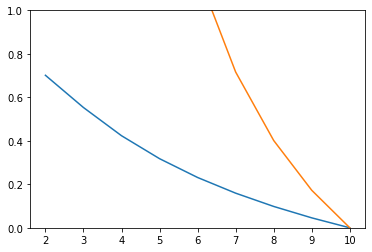

In [13]:
nums_sensors = np.arange(2, 11)

sigmas_intercept = calc_analytic_sigma_intercept(1., nums_sensors)
sigmas_slope = calc_analytic_sigma_slope(delta_x, 1., nums_sensors)

plt.plot(nums_sensors, (sigmas_intercept - sigmas_intercept[-1])/sigmas_intercept[-1])
plt.plot(nums_sensors, (sigmas_slope - sigmas_slope[-1])/sigmas_slope[-1])

plt.ylim([0, 1])

[3.5        2.17142857 2.10526316 3.25       2.34615385 2.29508197]


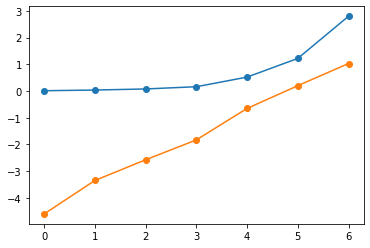

In [6]:
# z values from Pelletier & Field (2016)
zs = np.array([0.01, 0.035, 0.076, 0.16, 0.52, 1.22, 2.8]) # m
plt.plot(zs, marker='o')
plt.plot(np.log(zs), marker='o')

# Roughly logarithmic spacing
print(zs[1:]/zs[0:-1])

In [14]:
def calc_zstar_from_slope_and_intercept(z0, slope, intercept):
    return z0*np.exp(-intercept/slope)

def calc_analytic_ustar(kappa, x, y, sigma):
    return kappa*calc_slope(x, y, sigma)

def calc_analytic_zstar(z0, x, y, sigma):
    slope = calc_slope(x, y, sigma)
    intercept = calc_intercept(x, y, sigma)
    
    return calc_zstar_from_slope_and_intercept(z0, slope, intercept)

def calc_analytic_sigma_ustar(kappa, delta_x, sigma, N):
    return kappa*calc_analytic_sigma_slope(delta_x, sigma, N)

def calc_analytic_sigma_zstar(kappa, z0, delta_x, x, y, sigma):
    N = len(x)
    
    ustar = calc_analytic_ustar(kappa, x, y, sigma)
    zstar = calc_analytic_zstar(z0, x, y, sigma)
    intercept = calc_intercept(x, y, sigma)
    
    sigma_intercept = calc_analytic_sigma_intercept(sigma[0], N)
    sigma_ustar = calc_analytic_sigma_ustar(kappa, delta_x, sigma[0], N)
    
    return np.sqrt(sigma_intercept**2/ustar**2 - intercept**2*sigma_ustar**2)*kappa*zstar

zs = np.array([0.01, 0.035, 0.076, 0.16, 0.52, 1.22, 2.8]) # m
z0 = zs[0]
kappa = 0.4

# print(calc_slope(x, noisy_y, sigma), calc_intercept(x, noisy_y, sigma))
# print(calc_analytic_sigma_slope(delta_x, sigma[0], num_sensors), 
#       calc_analytic_sigma_intercept(sigma[0], num_sensors))
print(calc_analytic_ustar(kappa, x, y, sigma), calc_analytic_zstar(z0, x, y, sigma))
print(calc_analytic_ustar(kappa, x, noisy_y, sigma), calc_analytic_zstar(z0, x, noisy_y, sigma))
print(calc_analytic_sigma_ustar(kappa, delta_x, sigma[0], num_sensors), 
      calc_analytic_sigma_zstar(kappa, z0, delta_x, x, y, sigma))

print((calc_analytic_zstar(z0, x, y, sigma) - calc_analytic_zstar(z0, x, noisy_y, sigma))/\
      calc_analytic_sigma_zstar(kappa, z0, delta_x, x, y, sigma))

4.000000000000002 0.009048374180359616
4.054512219411328 0.00736999239547812
0.316227766016838 0.0033122487967006727
0.5067197206180072


---

What if measured velocities are distributed according to Weibull distribution? How many samples/how well do you need to sample the distribution to get good fit parameters?

The probability distribution function for Weibull $p(v)$ is
$$
p(v) = \dfrac{k}{\lambda} \left( \dfrac{v}{\lambda} \right)^{k-1} e^{-\left( v/\lambda \right)^k}
$$
with $k$ and $\lambda$ between 0 and $\infty$.

$p(v)$ has a mean $\langle v \rangle = \lambda \Gamma(1 + 1/k)$, with $\Gamma$ the Gamma function. The variance $\sigma^2 = \lambda^2 \bigg[ \Gamma(1 + 2/k) - \left( \Gamma(1 + 1/k) \right)^2\bigg]$.

Weibull has the cumulative distribution function $P(< v)$
$$
P(< v) = 1 - e^{-(v/\lambda)^k}.
$$

With a collection of measured wind velocities, we can make a histogram and then attempt to fit $k$ and $\lambda$ (as in Viudez-Moreiras+ (2017 - http://www-mars.lmd.jussieu.fr/granada2017/abstracts/viudez-moreiras_granada2017.pdf)), but this approach requires choosing bin sizes, which can affect the results. 

Working with the cumulative distribution function sidesteps this issue. Moreover, we can analytically solve for the uncertainties by slightly re-casting the problem.

$e^{-\left( v/\lambda \right)^k} = 1 - P(< v)$

$-(v/\lambda)^k = \ln \left(1 - P\right)$

$k\ln(v/\lambda) = \ln\left( \ln \left( 1/(1 - P) \right) \right)$

$k \ln v - k\ln \lambda = y$

$P$ will go from 0 to 1, meaning $\ln(1 - P)$ will go from 0 to $-\infty$...

Take $x \equiv v^k$ and the slope $b \equiv -(1/\lambda)^k$. $y \equiv \ln (1 - P)$

$k\left( v/\lambda \right) = \ln \left( \ln(1/(1 - P)) \right) $

$v = \lambda (\ln(x))^{(1/k)}$ such that $v = 0$ when $x = 1$ and $v \rightarrow \infty$ for $x \rightarrow \infty$.

$$
e^{-\left( \dfrac{\lambda (\ln x)^{1/k}}{\lambda} \right)^k} = 1 - P(< v)
$$

$ -x = 1 - P$

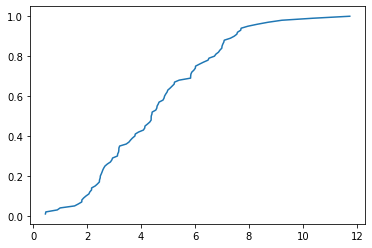

In [97]:
def Weibull_CDF(v, lamb, k):
    return 1 - np.exp(-(v/lamb)**k)

def Weibull_PDF(v, lamb, k):
    return (k/lamb)*(v/lamb)**k*np.exp(-(v/lamb)**k)

def inv_Weibull_CDF(p, lamb, k):
    return np.log(1./(1. - p))**(1./k)*lamb

def crazy_function(p):
    return np.log(np.log(1/(1 - p)))

def Weibull_mean(lamb, k):
    return lamb*gamma(1 + 1/k)

def Weibull_variance(lamb, k):
    return lamb**2*(gamma(1 + 2/k) - gamma(1 + 1/k)**2)

lamb = 5.
k = 2.

# Random
min_v = 0
max_v = 20. #m/s
num_velocities = 100
# v = np.sort(random(num_velocities)*(max_v - min_v) + min_v)
# plt.plot(v, Weibull_CDF(v, lamb, k))
# plt.plot(v, Weibull_PDF(v, lamb, k))

# ps = np.linspace(0., 1., 1000)
# plt.plot(ps, np.log(inv_Weibull_CDF(ps, lamb, k)))
# plt.plot(ps, crazy_function(ps))

vs = inv_Weibull_CDF(random(num_velocities), lamb, k)
hst, bin_edges = np.histogram(vs, bins=[*np.sort(vs), max_v + 1])
cum_hst = np.cumsum(hst, axis=0)
err_cum_hst = np.sqrt(cum_hst)
cum_hst = cum_hst / num_velocities
err_cum_hst = err_cum_hst / num_velocities
plt.plot(np.sort(vs), cum_hst)

[0.01318646 0.03394614]
correct mean, variance:  4.4311346272637895 5.365045915063796
fit mean, variance:  4.487445064345427 5.181598351839543
mismatch:  -0.012707904818592458 0.034193102189335293


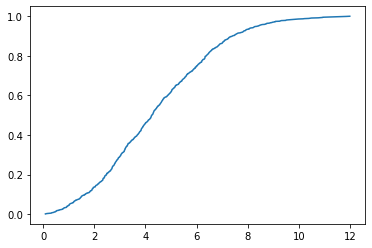

In [104]:
lamb = 5.
k = 2.

# Random
min_v = 0
max_v = 20. #m/s
num_velocities = 1000

vs = inv_Weibull_CDF(random(num_velocities), lamb, k)
hst, bin_edges = np.histogram(vs, bins=[*np.sort(vs), max_v + 1])
cum_hst = np.cumsum(hst, axis=0)
cum_hst = cum_hst / num_velocities
plt.plot(np.sort(vs), cum_hst)

popt, pcov = curve_fit(Weibull_CDF, np.sort(vs), cum_hst, p0=[5, 2])
unc = np.sqrt(np.diag(pcov))
print((popt - [lamb, k])/[lamb, k])
print("correct mean, variance: ", Weibull_mean(lamb, k), Weibull_variance(lamb, k))
print("fit mean, variance: ", Weibull_mean(*popt), Weibull_variance(*popt))
print("mismatch: ", (Weibull_mean(lamb, k) - Weibull_mean(*popt))/Weibull_mean(lamb, k), 
      (Weibull_variance(lamb, k) - Weibull_variance(*popt))/Weibull_variance(lamb, k))